# Sandbox for flow matching arch 

In [61]:
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset

from lightning import Trainer
from lightning.pytorch import LightningModule

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Simplest implementation

# Generate data

Notes
ELU: Exponential linear unit

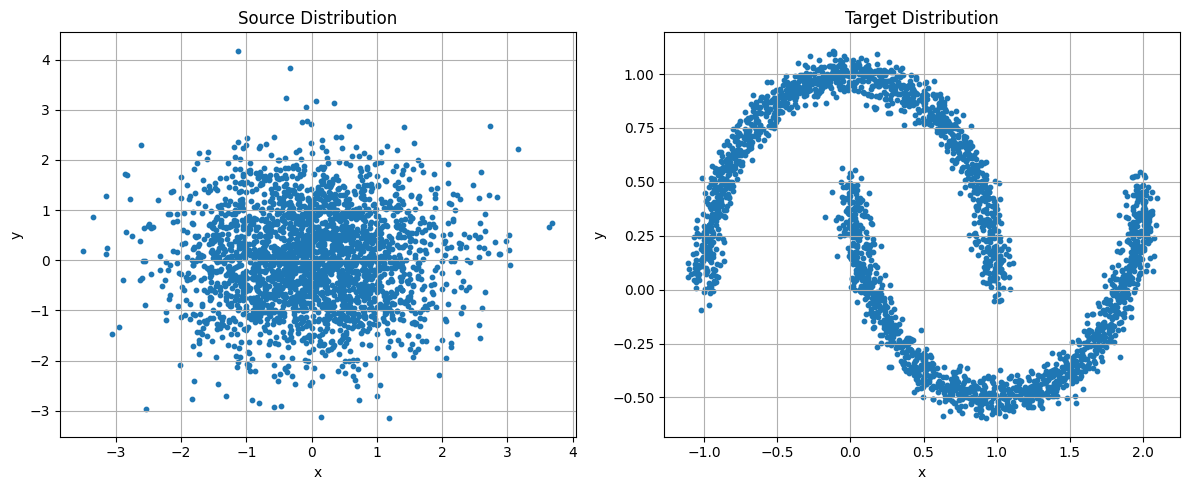

In [54]:
# Synthetic generation of 'true' data
nsamples = 256*10
x_data = Tensor(make_moons(nsamples, noise=0.05)[0])
x_rand = torch.randn_like(x_data) # just used for visualization

# Batch the data for dataloader
data_loader = DataLoader(TensorDataset(x_data), batch_size=256, shuffle=True)

# Plot synthetic data and random noise side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x_rand[:, 0], x_rand[:, 1], s=10)
ax1.set_title('Source Distribution')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True)

ax2.scatter(x_data[:, 0], x_data[:, 1], s=10)
ax2.set_title('Target Distribution')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [83]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        # For simplicity, using midpoint ODE solver in this example
        return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end - t_start) / 2,
                                            t_start + (t_end - t_start) / 2)

class FlowModel(LightningModule):
    """Lightning wrapper for flow model"""
    def __init__(self):
        super().__init__()
        self.flow =  Flow()
        self.loss = nn.MSELoss()
    def forward(self,  x: Tensor, t: Tensor) -> Tensor:
        h = torch.cat([x, t], dim=1)
        output = self.flow(h)
        return output

    def training_step(self, batch, batch_idx):
        x_target = batch
        x_source = torch.randn_like(x_target)
        t = torch.rand(len(x_source), 1)
        
        x_t = (1 - t) * x_source + t * x_target #calculate time-dependent position (linear interpolation)
        dx_t = x_target - x_source # calculate difference in positions
        vf = self.flow(x_t, t) # the predicted vector field
        loss = self.loss(vf, dx_t)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.flow.parameters(), 1e-2)
        return optimizer


In [107]:
# data opereations
n_samples = 256*10
x_data = Tensor(make_moons(nsamples, noise=0.05)[0])
dataloader = DataLoader(Tensor(x_data), batch_size=256, shuffle=True)

model = FlowModel()
trainer = Trainer(max_epochs=200)
trainer.fit(model, dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | flow | Flow    | 8.7 K  | train
1 | loss | MSELoss | 0      | train
-----------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


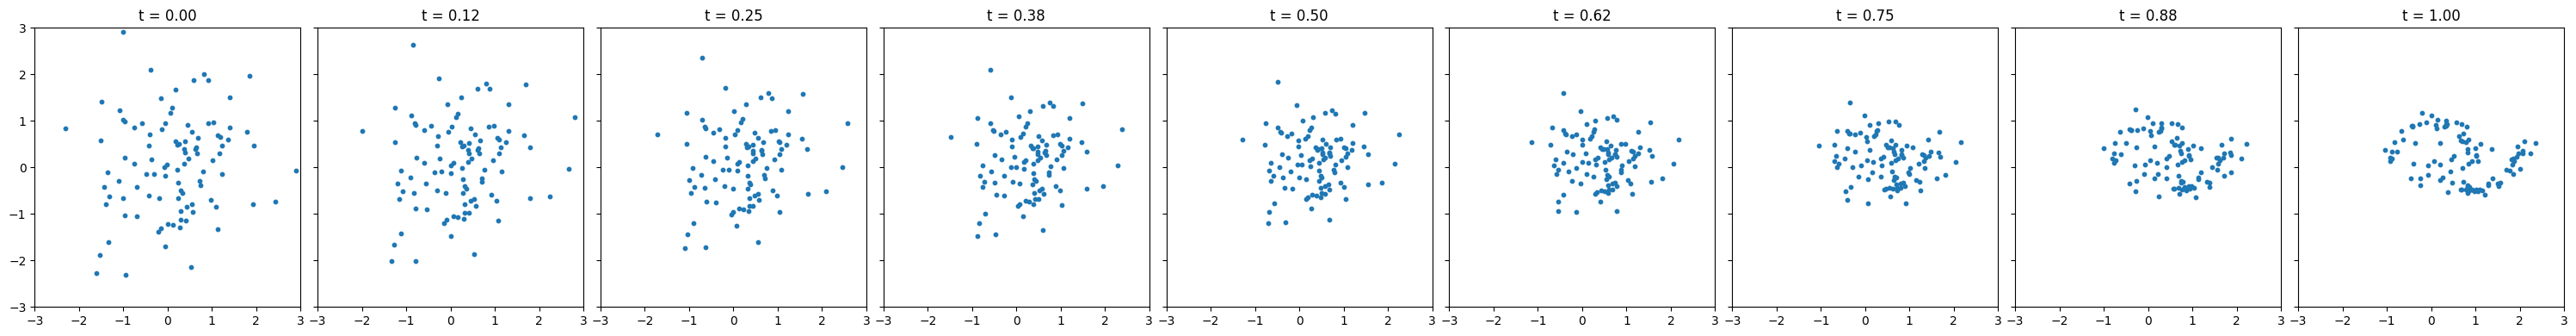

In [108]:
# Sample from model
x = torch.randn(100, 2)
n_steps = 8
time_steps = torch.linspace(0, 1.0, n_steps + 1)

fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = model.flow.step(x, time_steps[i], time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()